# Relax Challenge

**Prompt**

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [232]:
# imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [270]:
DIR = '/Users/allankapoor/Documents/Springboard/springboard/relax_challenge'
engagement = pd.read_csv(os.path.join(DIR, 'takehome_user_engagement.csv'))
users = pd.read_csv(os.path.join(DIR, 'takehome_users.csv'), encoding='latin-1')

In [271]:
engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [272]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [273]:
engagement.user_id.max()

12000

In [274]:
#convert time_stamp to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [275]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [276]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [278]:
#confirming that null values in invited_by_user_id are because they weren't invited
null_invite_signups = users.loc[users.invited_by_user_id.isnull(),:].creation_source.unique()
non_null_invite_signups = users.loc[~users.invited_by_user_id.isnull(),:].creation_source.unique()
print(f'Signup categories when invited_by_user_id is null: {null_invite_signups}')
print(f'Signup categories when invited_by_user_id is null: {non_null_invite_signups}')

Signup categories when invited_by_user_id is null: ['SIGNUP' 'PERSONAL_PROJECTS' 'SIGNUP_GOOGLE_AUTH']
Signup categories when invited_by_user_id is null: ['GUEST_INVITE' 'ORG_INVITE']


In [279]:
#convert creation_time from string to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])

#convert last_session_creation_time from unix to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', origin='unix')

In [280]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [353]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  is_adopted                  12000 non-null  int64         
 11  creation_dayofmonth         12000 non-null  int64     

## Create target variable

Per prompt, defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

*In other words:* for a given user is their 7-day rolling sum ever 3 or greater?

In [281]:
def is_adopted (row):
    
    '''For given row in users df, determine if user has logged in 3+ times in any 7 day period based on engagement df'''
    
    #get user id for that row
    user = row['object_id']
    
    #filter engagement df to that user
    user_df = engagement.loc[engagement.user_id == user, :].drop(columns=['user_id'])
    
    #if table is empty, user not adopted
    if len(user_df) == 0:
        return 0
    
    else:

        # resample filtered engagement df to 1 day increments
        logins_interval = user_df.resample("1D", on='time_stamp').count()

        # get rolling sum (7 day period)
        logins_interval_rolling = logins_interval.visited.rolling(window=7, min_periods=1).sum()

        # find max value of rolling sum
        week_max = logins_interval_rolling.max()

        if week_max >= 3:
            return 1
        else:
            return 0

In [282]:
# apply function above to generate target variable for each row
users['is_adopted'] = users.apply((lambda row: is_adopted(row)), axis=1)

In [283]:
# confirming users with null last_session_creation_time never have is_adopted == 0
users[users.last_session_creation_time.isnull()].is_adopted.sum()

0

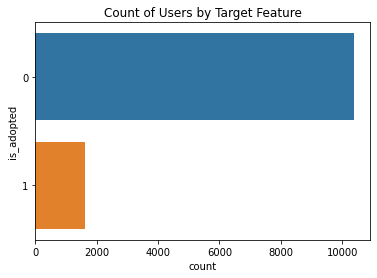

In [308]:
ax = sns.countplot(data=users, y='is_adopted')
ax.set_title('Count of Users by Target Feature')
plt.show()

In [316]:
target_count = users.groupby('is_adopted').count().object_id
target_pcnt = round(target_count.loc[1] / target_count.sum() * 100,2)
print(f'{target_pcnt}% of users have "adopted" the service')

13.35% of users have "adopted" the service


### Feature Generation

Since there aren't a lot of features to predict on, let's create a few:
 * Day of year and day of month account was created
 * Number of users in org user is part of
 * Number of active users in org user is part of
 * Proportion of users who are active in org user is part of
 * Binary flag if user has invited others

In [285]:
#Creation day of the year and month
users['creation_dayofmonth'] = pd.DatetimeIndex(users.creation_time).day
users['creation_dayofyear'] = pd.DatetimeIndex(users.creation_time).dayofyear

In [286]:
#number of users by org
users_by_org = pd.DataFrame(users.groupby('org_id').count().email).sort_values('email', ascending=False)
users_by_org = users_by_org.rename(columns={'email':'org_num_users'})
users = users.merge(users_by_org, on='org_id', how='left')

In [287]:
#number of adopted users by org
adopted_users_by_org = pd.DataFrame(users.groupby('org_id').sum().is_adopted).sort_values('is_adopted', ascending=False)
adopted_users_by_org = adopted_users_by_org.rename(columns={'is_adopted':'org_num_active_users'})
users = users.merge(adopted_users_by_org, on='org_id', how='left')

In [288]:
#proportion of users active for org member is part of
users['org_pcnt_adopted'] = round(users.org_num_active_users / users.org_num_users * 100, 2)

In [289]:
#is user inviting others?
users_who_invite = users.invited_by_user_id.unique()
users['invites_others'] = users.apply((lambda row: 1 if row['object_id'] in users_who_invite else 0), axis=1)

In [290]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  is_adopted                  12000 non-null  int64         
 11  creation_dayofmonth         12000 non-null  int64     

## EDA of Continuous Variables

Below I plotted box plots and bar chart of means comparing each continuous variable to the target variable. A histogram shows the distribution of the continuous variable. 

/Users/allankapoor/miniforge3/envs/tf_env_2/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


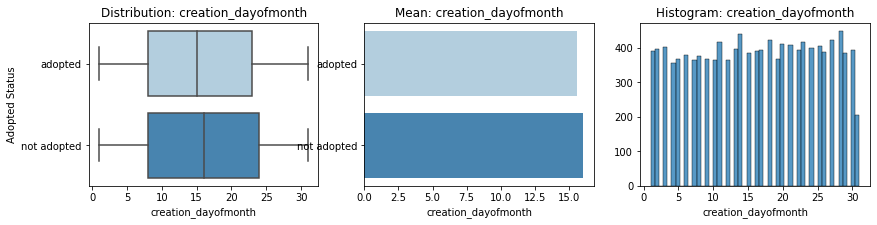

Two-tailed T test
t: -2.0602
p: 0.0395


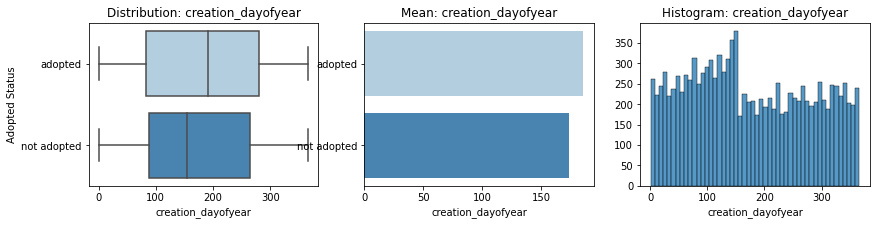

Two-tailed T test
t: 4.135
p: 0.0


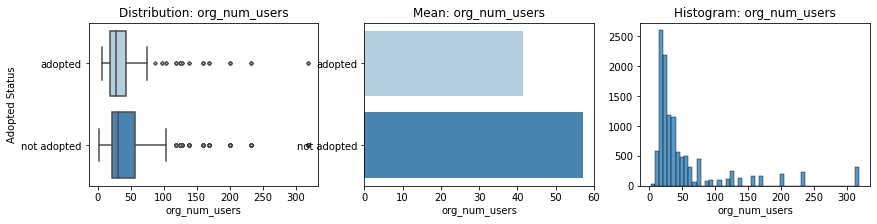

Two-tailed T test
t: -12.0972
p: 0.0


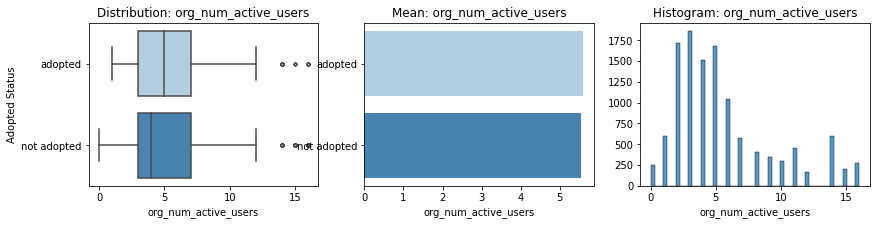

Two-tailed T test
t: 0.6549
p: 0.5126


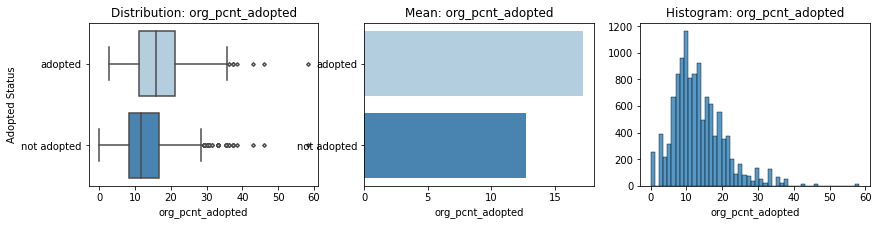

Two-tailed T test
t: 20.5042
p: 0.0


In [292]:
# list of continuous features + target variable
cols= ['is_adopted','creation_dayofmonth', 'creation_dayofyear', 'org_num_users',
       'org_num_active_users', 'org_pcnt_adopted']

# create dataframe for holding statistical test results
ttest_df = pd.DataFrame(data=cols[1:],columns=['Feature'])
ttest_df.set_index('Feature', inplace=True)
ttest_df['T-Score']=np.nan
ttest_df['P Value']=np.nan

# df with continous vars only
df = users[cols]
df.loc[:,'is_adopted'] = df.apply((lambda row: 'adopted' if row['is_adopted']==1 else 'not adopted'), axis=1)

# style for boxplot outlier marks  
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none', marker='.')

# for each continuous feature: plot boxplot (by size), bar plot of means (by size), and histogram
# two-tailed t test, print t and p
for i, col in enumerate(df.columns[1:]):
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 3))
    
    # boxplot 
    sns.boxplot(x=col, y='is_adopted', data=df, palette='Blues', flierprops=flierprops, ax=ax1, order=['adopted','not adopted'])

    # bar plot of means
    mean_table = df.groupby('is_adopted')[col].mean()
    sns.barplot(y=mean_table.index, x=mean_table, palette='Blues', ax=ax2,  order=['adopted','not adopted'])
    
    # histogram
    sns.histplot(x=col, data=df, ax=ax3, bins=50)
    
    # set titles, labels
    ax1.set_title('Distribution: '+col)
    ax1.set_ylabel('Adopted Status')
    ax2.set_title('Mean: '+col)
    ax2.set_ylabel('')
    ax3.set_title('Histogram: '+col)
    ax3.set_ylabel('')
    
    plt.show()
    
    #statistical test
    active_users = df[df['is_adopted']=='adopted']
    nonactive_users = df[df['is_adopted']=='not adopted']
    t, p = stats.ttest_ind(active_users[col], nonactive_users[col], equal_var=False)
    t = round(t,4)
    p = round(p,4)
    ttest_df.loc[col,'T-Score'] = t
    ttest_df.loc[col,'P Value'] = p
    
    print('Two-tailed T test')
    print(f't: {t}')
    print(f'p: {p}')

## Statistical Tests of Continuous Variables

Two tailed T-tests for continuous variables vs target variable (adopted or not adopted). We see that all continuous variables appear to have a statistically significant relationship except for org_num_active_users (P<0.05).

In [293]:
ttest_df

,T-Score,P Value
Feature,,
creation_dayofmonth,-2.0602,0.0395
creation_dayofyear,4.1350,0.0000
org_num_users,-12.0972,0.0000
org_num_active_users,0.6549,0.5126
org_pcnt_adopted,20.5042,0.0000


## Categorical features

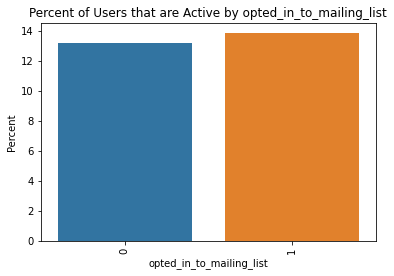

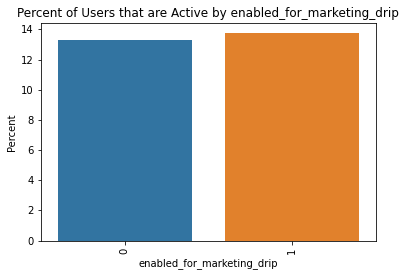

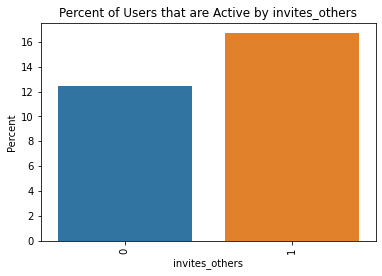

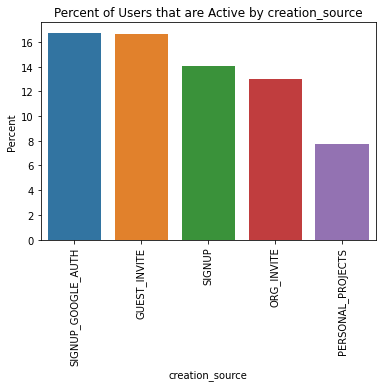

In [361]:
cat_feats = ['is_adopted','opted_in_to_mailing_list', 'enabled_for_marketing_drip','invites_others','creation_source']

users_cat = users.loc[:,cat_feats]



for feat in cat_feats[1:]:
    
    crosstab = pd.crosstab(users_cat['is_adopted'], users_cat[feat]).T
    crosstab['Pcnt_Active'] = round(crosstab[1]/(crosstab[1]+crosstab[0])*100,2)
    crosstab.sort_values('Pcnt_Active', ascending=False, inplace=True)
    sns.barplot(x=crosstab.index, y=crosstab.Pcnt_Active)
    locs, labels = plt.xticks()
    plt.ylabel('Percent')
    plt.xlabel(feat)
    plt.title(f'Percent of Users that are Active by {feat}')
    plt.setp(labels, rotation=90)
    plt.show()

In [332]:
from sklearn.feature_selection import chi2
chi2, pvalues = chi2(users[bin_cat], users['is_adopted'])
chi2 = chi2.round(3)
pvalues = pvalues.round(3)

In [333]:
pd.DataFrame([chi2, pvalues], columns=bin_cat, index=['chi2','pvalues'])

,opted_in_to_mailing_list,enabled_for_marketing_drip,invites_others
chi2,0.591,0.221,24.766
pvalues,0.442,0.638,0.000


Opted in to mailing list is 

enabled_for_marketing_drip is not significant

Invites others appears to have a strong relationship (high chi2 value) that is statistically significiant (p<0.001)